## <b> <span style='color:#e61227'>|</span> Convolutional Neural Network for Diabetic Retinopathy Detection (Pytorch) </b> 

In [2]:
# Import essential libreries
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import copy 
import os 
import torch
from PIL import Image 
from torch.utils.data import Dataset 
import torchvision
import torchvision.transforms as transforms 
from torch.optim.lr_scheduler import ReduceLROnPlateau  
import torch.nn as nn 
from torchvision import utils 
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
from sklearn.metrics import classification_report
import itertools 
from tqdm.notebook import trange, tqdm 
from torch import optim
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


![](https://domf5oio6qrcr.cloudfront.net/medialibrary/14372/0b26ebff-2421-4333-aedc-bb17dfc37541.jpg)

## <b>1 <span style='color:#e61227'>|</span> Introduction</b> 

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>1.1 |</span></b> Why do we need this study?</b></p>
</div>


The prevalence of diabetic retinopathy is alarmingly high, affecting a significant proportion of individuals with long-standing diabetes. Early detection and timely treatment are crucial for preventing vision loss and improving patient outcomes. However, manual interpretation of retinal images for diabetic retinopathy screening can be time-consuming and subject to human error. Therefore, there is a pressing need for an automated and accurate tool that can assist healthcare professionals in grading the severity of diabetic retinopathy.

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>1.2 |</span></b> Problem Statement</b></p>
</div>

The existing methods for detecting and grading **Diabetic Retinopathy** often rely on subjective assessments and extensive manual labor, leading to inefficiencies and potential inconsistencies in diagnosis. Moreover, the increasing prevalence of diabetes and the limited availability of ophthalmologists further exacerbate the challenges in timely screening and diagnosis. Therefore, there is a need to develop a robust and reliable automated system that can accurately detect and grade diabetic retinopathy, enabling early intervention and personalized treatment plans.


<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>1.3 |</span></b> Study Aim</b></p>
</div>

This project aims to employ **Convolutional Neural Networks (CNNs)** for diabetic retinopathy detection using PyTorch, a popular deep learning framework. By leveraging the power of **Deep Learning Algorithms**, we aim to develop a model that can analyze retinal images and accurately classify them based on the severity of **Diabetic Retinopathy**. This study seeks to provide an automated and efficient solution to assist healthcare professionals in diagnosing and grading diabetic retinopathy, ultimately improving patient care and reducing the risk of vision loss.

## <b>2 <span style='color:#e61227'>|</span> Dataset</b> 

**Data Description** :
This dataset consists of a large collection of high-resolution retinal images captured under various imaging conditions. A medical professional has assessed the presence of Diabetic Retinopathy in each image and assigned a rating on a scale ranging between 0 and 1, which corresponds to the following categories:

- Diabetic Retinopathy ---> **0**
- No Diabetic Retinopathy ---> **1**

## <b>3 <span style='color:#e61227'>|</span>  Data Preparation </b> 

In [4]:
# Define Transformation
transform = transforms.Compose(
    [
        transforms.Resize((255,255)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)


In [5]:
# Define object of the Train, Validation, and Test dataset.
train_set = torchvision.datasets.ImageFolder("/kaggle/input/diagnosis-of-diabetic-retinopathy/train", transform=transform) 
train_set.transform
val_set = torchvision.datasets.ImageFolder("/kaggle/input/diagnosis-of-diabetic-retinopathy/valid", transform=transform)
val_set.transform
test_set = torchvision.datasets.ImageFolder("/kaggle/input/diagnosis-of-diabetic-retinopathy/test", transform=transform)
test_set.transform

Compose(
    Resize(size=(255, 255), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

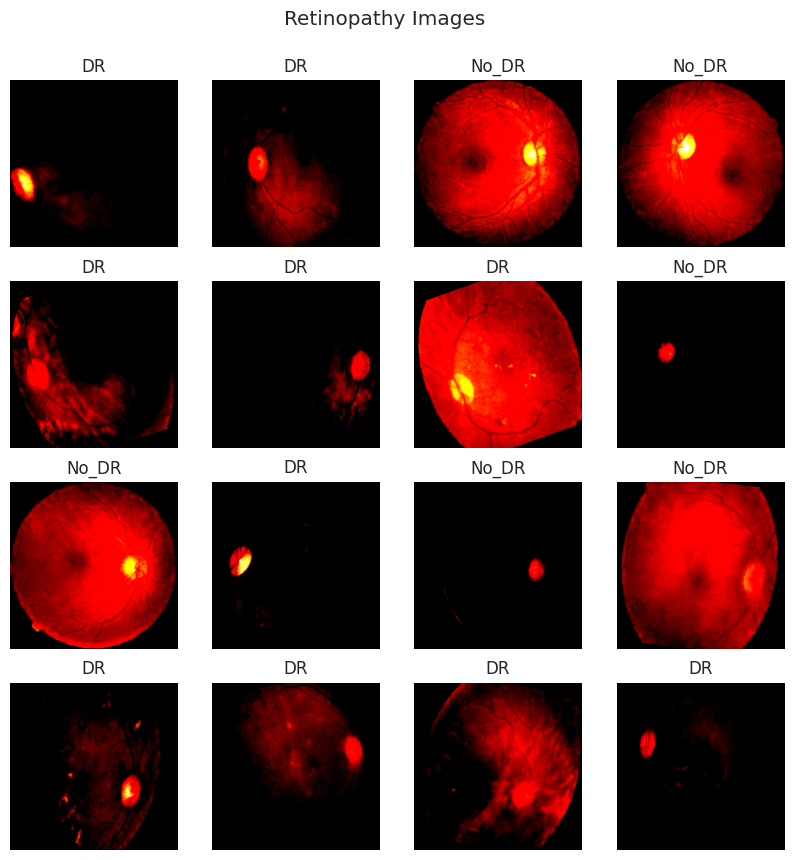

In [6]:
# Visualizing some images from Trainset
CLA_label = {
        0 : 'DR',
        1 : 'No_DR',
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Retinopathy Images', y=0.95)
plt.show()

## <b>5 <span style='color:#e61227'>|</span> Creating Dataloaders</b> 

In [7]:
# Import and load Train, Validation and Test set
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

In [8]:
# Print shape of Dataset
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 255, 255])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 255, 255])
Shape of y: torch.Size([64]) torch.int64



## <b>6 <span style='color:#e61227'>|</span> Define Diabetic Retinopathy Classifier</b> 

In [10]:
'''This function can be useful in determining the output size of a convolutional layer,
given the input dimensions and the convolutional layer's parameters.'''

def findConv2dOutShape(hin,win,conv,pool=2):
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [11]:
# Define Architecture For Retinopathy Model
class CNN_Retino(nn.Module):
    
    def __init__(self, params):
        
        super(CNN_Retino, self).__init__()
    
        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"] 
        num_fc1 = params["num_fc1"]  
        num_classes = params["num_classes"] 
        self.dropout_rate = params["dropout_rate"] 
        
        # CNN Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [12]:
params_model={
        "shape_in": (3,255,255), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.15,
        "num_classes": 2}

# Create instantiation of Network class
Retino_model = CNN_Retino(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Retino_model = Retino_model.to(device)

In [13]:
# Model Summary for CNN_Retino
summary(Retino_model, input_size=(3, 255, 255),device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0

## <b>7 <span style='color:#e61227'>|</span> Loss Function Definition</b> 

In [14]:
loss_func = nn.NLLLoss(reduction="sum")

## <b>8 <span style='color:#e61227'>|</span> Optimiser Definition</b> 

In [15]:
opt = optim.Adam(Retino_model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

## <b>9 <span style='color:#e61227'>|</span> Training Model</b> 

In [16]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>9.2 |</span></b>Training Function</b></p>
</div>

In [17]:
def train_val(model, params, verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    # history of loss values in each epoch
    loss_history={"train": [],"val": []} 
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []} 
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict()) 
    # initialize best loss to a large value
    best_loss=float('inf') 

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.) 
    
    for epoch in tqdm(range(epochs)):
        
        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        
# Train Model Process

        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        

# Evaluate Model Process

        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>9.3 |</span></b> Training Process </b></p>
</div>

In [18]:
# Define various parameters used for training and evaluation of a cnn_model

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 60,
 "optimiser": optim.Adam(Retino_model.parameters(),lr=1e-4),
 "lr_change": ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# train and validate the model
model,loss_hist_m,metric_hist_m = train_val(Retino_model,params_train)

  0%|          | 0/60 [00:00<?, ?it/s]

## <b>10 <span style='color:#e61227'>|</span> Evaluation Metric Visualization</b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>10.1 |</span></b> Loss and Acccuracy Of Model </b></p>
</div>

<Axes: >

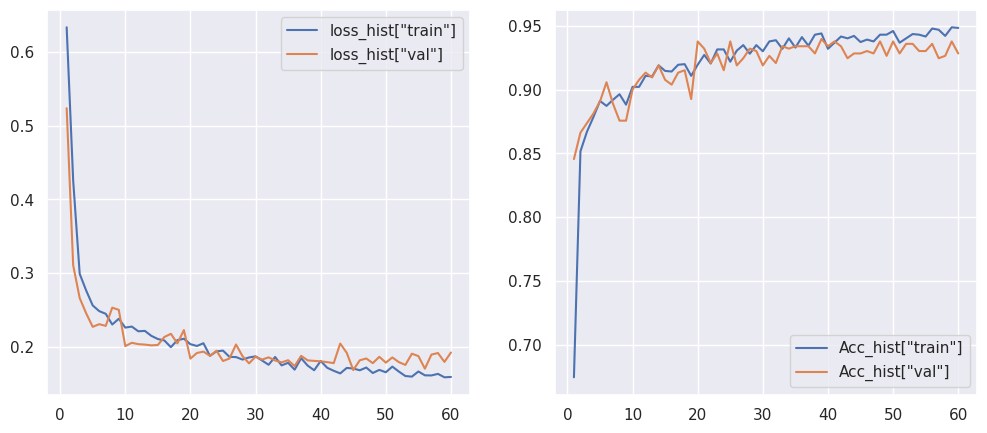

In [19]:
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["val"],ax=ax[1],label='Acc_hist["val"]')

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>10.2 |</span></b> Classification Report </b></p>
</div>

In [20]:
# Define Function For Classification Report
def ture_and_pred_data(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred


In [21]:
# Classification Report for Retinopathy Classification Model based on Train Set
y_true, y_pred = ture_and_pred_val(train_loader, Retino_model)
print(classification_report(y_true, y_pred), '\n\n')

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94      1050
         1.0       0.91      0.98      0.94      1026

    accuracy                           0.94      2076
   macro avg       0.95      0.94      0.94      2076
weighted avg       0.95      0.94      0.94      2076
 




In [22]:
# # Classification Report for Retinopathy Classification Model based on Validation Set
y_true, y_pred = ture_and_pred_val(val_loader, Retino_model)
print(classification_report(y_true, y_pred), '\n\n')


              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93       245
         1.0       0.92      0.97      0.94       286

    accuracy                           0.94       531
   macro avg       0.94      0.93      0.94       531
weighted avg       0.94      0.94      0.94       531
 




## <b>11<span style='color:#e61227'>|</span> Save Model </b>

In [23]:
torch.save(Retino_model, "Retino_model.pt")

## <b>13<span style='color:#e61227'>|</span> Detection Retinopathy By Real Image</b>

In [24]:
# Load the pretrained model
model = torch.load("Retino_model.pt")

# Move the model to the GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Iterate over the test loader for prediction
with torch.no_grad():
    for images, _ in test_loader:
        
        images = images.to(device)
        output = model(images)
        probabilities = torch.softmax(output, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        
        for predicted_class in predicted_classes:
            print("Predicted class:", predicted_class.item())

Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted cl

In [25]:
## Classification Report for Retinopathy Classification Model based on Test set
y_true, y_pred = ture_and_pred_val(test_loader, model)
print(classification_report(y_true, y_pred), '\n\n')

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94       113
         1.0       0.91      0.98      0.95       118

    accuracy                           0.94       231
   macro avg       0.95      0.94      0.94       231
weighted avg       0.95      0.94      0.94       231
 





<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'></span></b> Thank you for taking the time to review my notebook. If you have any questions or criticisms, please kindly let me know in the comments section.</b></p>
</div>
